# Modelling pressure

The pulsatility dataset is clearly very sensitive to pressure, so I thought before modelling the rest of the data it would make sense to try and understand how pressure depends on other variables.

In [1]:
import json
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

from matplotlib import pyplot as plt
from pprint import pprint
from sphincter.data_preparation import load_prepared_data

INFERENCES_DIR = os.path.join("..", "inferences")
PLOTS_DIR = os.path.join("..", "plots")
ARVIZ_STYLE = "arviz-redish"

plt.style.use(ARVIZ_STYLE)

In [4]:
prepared_data = load_prepared_data("../data/prepared/pressure.json")
msts = prepared_data.measurements
msts.head()

,mouse,age,treatment,map,pp,hr
0,11020,adult,ablation,48.490100,10.969394,5.112988
1,11020,adult,after_hyper1,50.055069,12.031981,5.178857
2,11020,adult,baseline,60.587775,12.960534,5.155377
3,11020,adult,hyper1,96.987509,13.702829,5.800671
4,11020,adult,hyper2,92.368492,8.044521,5.777388


[]

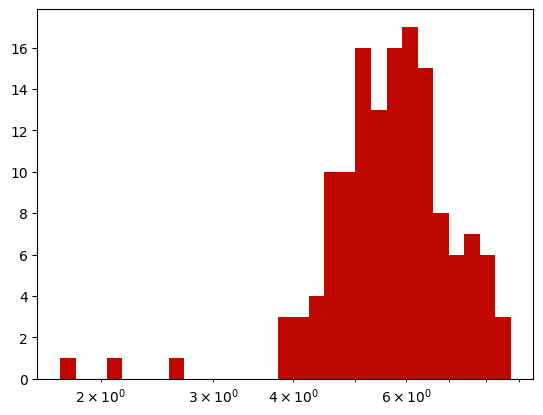

In [27]:
col = "HR"
f, ax = plt.subplots()
bins = np.logspace(np.log(raw[col].min()), np.log(raw[col].max()), 30, base=np.e)
ax.hist(raw[col], bins=bins)
ax.semilogx()

In [22]:
bins

array([  2584.57068105,   2934.50555196,   3331.81943818,   3782.92716511,
         4295.11208576,   4876.64367408,   5536.91103959,   6286.57451914,
         7137.73779316,   8104.14330552,   9201.3941419 ,  10447.2059492 ,
        11861.69296323,  13467.69276286,  15291.13499371,  17361.46001493,
        19712.09422807,  22380.98976251,  25411.23723101,  28851.76144856,
        32758.11134724,  37193.35684067,  42229.10711836,  47946.66681077,
        54438.34869204,  61808.96411449,  70177.51523872,  79679.11638122,
        90467.17550052, 102715.8710431 ])

In [2]:
data = load_prepared_data("../data/prepared/q2")
msts = data.measurements
msts.head().T

,951,952,953,954,949
age,adult,adult,adult,adult,adult
mouse,100920,100920,100920,100920,100920
vessel_type,bulb,cap1,cap2,cap3,pen_art
treatment,baseline,baseline,baseline,baseline,baseline
pd1,2092.769661,248.834511,91.102217,71.696774,713.220873
pd2,230.101368,22.605898,17.483219,13.260128,32.719247
pd3,NaN,4.536618,NaN,NaN,NaN
pd_sum,2322.87103,275.977028,108.585437,84.956902,745.940119
pd_ratio,0.099059,0.081912,0.161009,0.156081,0.043863
pc1,429.023989,110.760211,799.006296,333.158678,60.922862


The plot below shows the pressure for each mouse at each measurement

/var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/ipykernel_6738/2312929143.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mouse_to_age = msts.groupby("mouse")["age"].first()


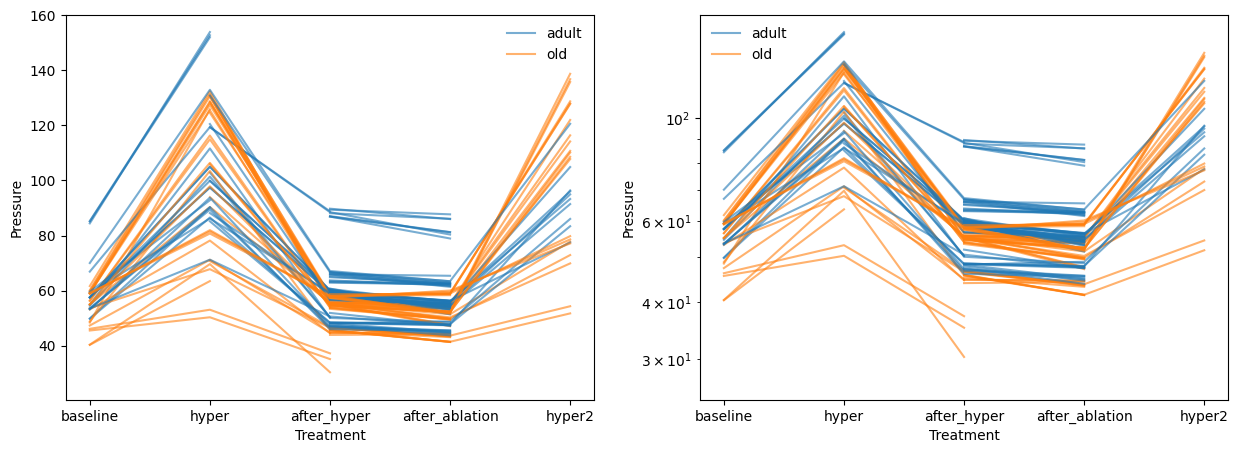

In [3]:
d = msts.reset_index().groupby(["treatment", "mouse", "vessel_type"], observed=True)["pressure_d"].first().unstack("treatment")
mouse_to_age = msts.groupby("mouse")["age"].first()

f, axes = plt.subplots(1, 2, figsize=[15, 5])

x = np.linspace(*axes[0].get_xlim(), len(d.columns))

for ax in axes:
    for (mouse, _), row in d.iterrows():
        age = mouse_to_age[mouse]
        if age == "adult":
            adult_plot, = ax.plot(x, row, color="tab:blue", label=age, alpha=0.6);
        else:
            old_plot, = ax.plot(x, row, color="tab:orange", label=age, alpha=0.6);
        
    ax.set_xticks(x, d.columns);
    ax.set(xlabel="Treatment", ylabel="Pressure");
    ax.legend([adult_plot, old_plot], ["adult", "old"], frameon=False);
axes[1].semilogy();

Problems - sometimes the pipe for measuring blood pressure might get clogged; usually this results in no measurement but maybe also sometimes a bias. 

Sometimes the surgery results in blood loss, which reduces blood pressure.

There is a lot of variation between mice. Old mice are often unhealthy, mice have different personalities etc. Even from measurement to measurement there is some variation.



Clearly, as you might expect, the "hyper" and "hyper2" treatments tended to increase the mice's blood pressure.

For the other treatments, eahc mouse's pressure is more or less the same as in the baseline case.

There is more variation in pressure for the hyper and hyper2 cases, though as the left hand figure shows the variation is more or less constant on log scale. Either way the variation among mice is pretty large, covering most of the difference between baseline and hypertension.

There are some mice with extreme pressure measurements that did not finish the protocol: these measurements should maybe be excluded.

The graph above doesn't seem to show a strong age difference. However, plotting the mean pressure by age for each treatment does seem to show a systematic difference in the baselines:

/var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/ipykernel_6738/2826289861.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dmean = d.join(mouse_to_age).groupby("age").mean()


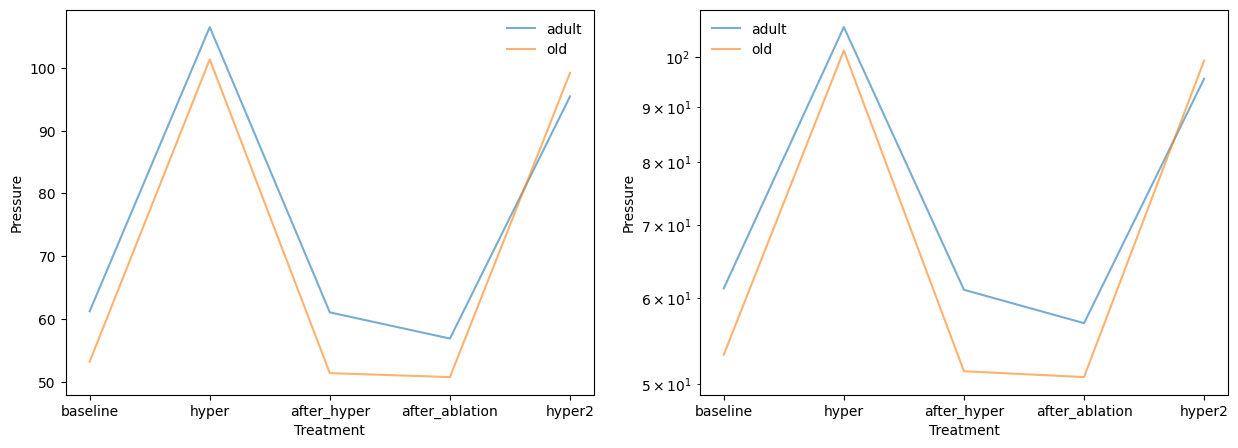

In [4]:
dmean = d.join(mouse_to_age).groupby("age").mean()

f, axes = plt.subplots(1, 2, figsize=[15, 5])

x = np.linspace(*axes[0].get_xlim(), len(d.columns))

for ax in axes:
    adult_plot, = ax.plot(x, dmean.loc["adult"], color="tab:blue", label=age, alpha=0.6);
    old_plot, = ax.plot(x, dmean.loc["old"], color="tab:orange", label=age, alpha=0.6);
    ax.set_xticks(x, d.columns);
    ax.set(xlabel="Treatment", ylabel="Pressure");
    ax.legend([adult_plot, old_plot], ["adult", "old"], frameon=False);
axes[1].semilogy();

<Axes: ylabel='Frequency'>

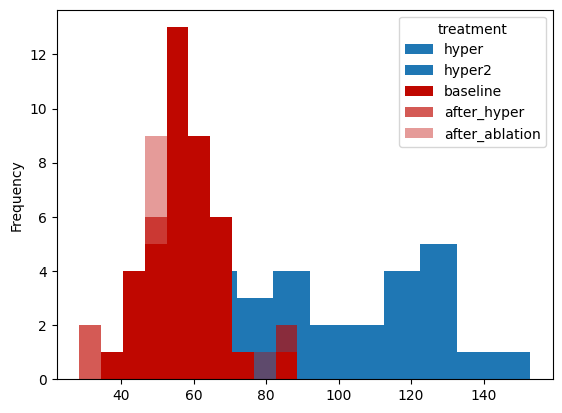

In [30]:
t = msts.groupby(["mouse", "treatment"], observed=True)["pressure_d"].mean().unstack()

hypercols = ["hyper", "hyper2"]
f, ax = plt.subplots()
t[hypercols].plot(kind="hist", ax=ax, color="tab:blue")
t[[c for c in t.columns if c not in hypercols]].plot(kind="hist", ax=ax)

To model this we will assume each mouse $m$ has two latent parameters: their baseline pressure $\lambda_m$ and the increase $\delta_m$ due to the hypertension drug. The non-"hyper" measurements are assumed to measure $\lambda_m$ directly and the "hyper" measurements measure $\lambda_m + \delta_m$.

We will assume that the $lambda$ parameters depend on age according to this distribution:

$$
\lambda_m \sim N(\mu^{\lambda} + a^{age}_{age(m)}, \tau^{lambda})
$$

The $\delta$ parameters are assumed not to depend on age:

$$
\delta_m \sim N(\mu^{\delta}, \tau^{\delta})
$$


In [5]:
idata = az.InferenceData.from_zarr(os.path.join(INFERENCES_DIR, "pressure", "idata"))

In [6]:
msts.assign(treatment_stan=idata.observed_data["treatment"].values).groupby("treatment")["treatment_stan"].unique()

/var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/ipykernel_6738/2781237968.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  msts.assign(treatment_stan=idata.observed_data["treatment"].values).groupby("treatment")["treatment_stan"].unique()


treatment
baseline          [1]
hyper             [3]
after_hyper       [2]
after_ablation    [4]
hyper2            [5]
Name: treatment_stan, dtype: object

/var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/ipykernel_6738/2739142020.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mouse_to_age = msts.groupby("mouse")["age"].first()


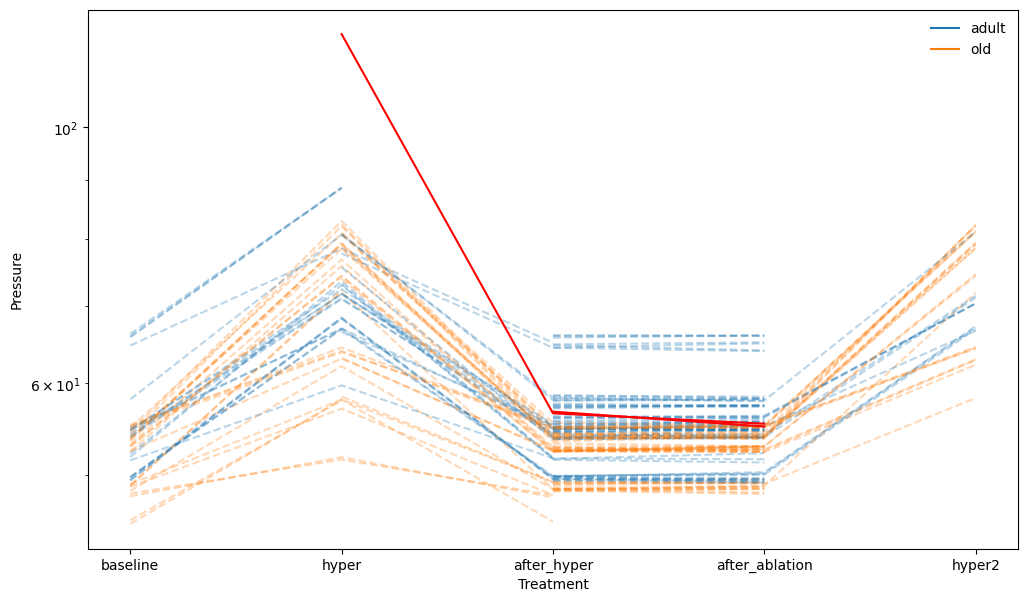

In [40]:
t = msts.assign(
    pressure_hat_mean=idata.posterior_predictive["yrep"].mean(dim=["chain", "draw"]),
    pressure_hat_pct1=idata.posterior_predictive["yrep"].quantile(0.01, dim=["chain", "draw"]),
    pressure_hat_pct99=idata.posterior_predictive["yrep"].quantile(0.99, dim=["chain", "draw"]),
)

d = (
    t.reset_index()
    .groupby(["treatment", "mouse", "vessel_type"], observed=True)
    [["pressure_d", "pressure_hat_mean", "pressure_hat_pct1", "pressure_hat_pct99"]]
    .first()
    .unstack("treatment")
)
mouse_to_age = msts.groupby("mouse")["age"].first()

f, ax = plt.subplots(figsize=[12, 7])

x = np.linspace(*ax.get_xlim(), len(d["pressure_d"].columns))


for (mouse, _), row in d.iterrows():
    age = mouse_to_age[mouse]
    if age == "adult":
        # adult_plot_obs, = ax.plot(x, row["pressure_d"], color="tab:blue", label=age, alpha=1);
        adult_plot_mean, = ax.plot(x, row["pressure_hat_pct1"], color="tab:blue", linestyle="--", label=age, alpha=0.3);

    else:
        # old_plot_obs, = ax.plot(x, row["pressure_d"], color="tab:orange", label=age, alpha=1);
        old_plot_mean, = ax.plot(x, row["pressure_hat_pct1"], color="tab:orange", linestyle="--", label=age, alpha=0.3);
    if mouse in [260520]:
        weird_plot, = ax.plot(x, row["pressure_d"], color="red", label="weird", alpha=1, zorder=9);


ax.set_xticks(x, d["pressure_d"].columns);
ax.set(xlabel="Treatment", ylabel="Pressure");
ax.legend([adult_plot_obs, old_plot_obs], ["adult", "old"], frameon=False);
ax.semilogy();

In [8]:
az.summary(idata, var_names=["mu", "sigma", "tau", "a_age"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_age[adult],0.060,0.577,-1.003,1.175,0.014,0.010,1607.0,2341.0,1.01
a_age[old],-0.243,0.578,-1.281,0.906,0.014,0.010,1601.0,2230.0,1.01
mu_delta,1.039,0.074,0.891,1.169,0.004,0.003,336.0,783.0,1.03
mu_lambda,-0.123,0.576,-1.230,0.945,0.015,0.010,1570.0,2246.0,1.01
sigma,0.082,0.004,0.075,0.088,0.000,0.000,4095.0,2406.0,1.00
tau_delta,0.372,0.059,0.268,0.480,0.002,0.002,662.0,1256.0,1.01
tau_lambda,0.281,0.033,0.220,0.345,0.001,0.001,615.0,993.0,1.01


In [9]:
az.summary(idata, var_names=["delta"], filter_vars="like").sort_values("mean")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta_z[40],-2.036,0.406,-2.823,-1.294,0.016,0.012,612.0,1145.0,1.02
delta_z[36],-1.268,0.300,-1.861,-0.743,0.014,0.010,464.0,1107.0,1.02
delta_z[33],-1.154,0.333,-1.787,-0.530,0.013,0.009,645.0,1397.0,1.02
delta_z[21],-1.117,0.397,-1.855,-0.382,0.013,0.009,904.0,1816.0,1.01
delta_z[30],-0.974,0.318,-1.558,-0.356,0.012,0.009,637.0,1357.0,1.02
...,...,...,...,...,...,...,...,...,...
delta_z[35],1.430,0.304,0.867,1.980,0.013,0.009,519.0,1240.0,1.01
delta[310321],1.436,0.038,1.362,1.504,0.001,0.000,4341.0,3123.0,1.00
delta[41021],1.479,0.078,1.322,1.612,0.001,0.001,5545.0,2998.0,1.00
delta[90321],1.546,0.126,1.340,1.819,0.002,0.001,5907.0,2628.0,1.01


In [10]:
loo = az.loo(idata, pointwise=True)
loo

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 626 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   448.90    28.25
p_loo       81.16        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      610   97.4%
 (0.5, 0.7]   (ok)         12    1.9%
   (0.7, 1]   (bad)         3    0.5%
   (1, Inf)   (very bad)    1    0.2%

In [11]:
msts.assign(k=loo.pareto_k.values).loc[lambda df: df["k"] > 0.65].T

,72,430,1247,1279,1277,1183
age,adult,adult,old,old,old,old
mouse,260520,300920,150720,170620,170620,70720
vessel_type,pen_art,bulb,bulb,bulb,pen_art,bulb
treatment,hyper,hyper,hyper,hyper,hyper,hyper
pd1,215.286222,462.218101,18.708308,293.172147,743.6528,52.933618
pd2,0.876429,50.610804,5.979673,15.618191,30.462182,40.838075
pd3,0.893784,4.496146,9.223711,1.860034,14.929824,NaN
pd_sum,217.056435,517.325051,33.911693,310.650373,789.044806,93.771694
pd_ratio,0.004038,0.097832,0.176331,0.050276,0.038606,0.435505
pc1,212.767922,44.437159,449.017578,221.476861,143.070997,153.668065


In [37]:
msts.query("mouse == 260520")

,age,mouse,vessel_type,treatment,pd1,pd2,pd3,pd_sum,pd_ratio,pc1,pc2,pc3,pc_sum,pc_ratio,pressure_d
79,adult,260520,cap1,after_hyper,206.067983,13.617997,1.044582,220.730562,0.061695,2704.397049,314.080513,60.689831,3079.167393,0.102002,56.583108
88,adult,260520,cap2,after_ablation,1679.258947,163.089310,29.578334,1871.926592,0.087124,3469.456754,528.186813,97.845215,4095.488782,0.128968,55.038343
80,adult,260520,cap2,after_hyper,137.712840,8.844193,1.906244,148.463277,0.059572,6428.914670,859.981554,153.411639,7442.307863,0.115553,56.696703
82,adult,260520,cap4,after_hyper,79.668936,40.734438,NaN,120.403374,0.338316,6.475552,4.582285,NaN,11.057837,0.414393,56.312234
84,adult,260520,pen_art,after_ablation,89.964757,28.719220,9.240166,127.924143,0.224502,149.679865,19.021956,2.169270,170.871091,0.111323,55.351124
76,adult,260520,pen_art,after_hyper,1433.668827,257.597897,51.801772,1743.068497,0.147784,527.530990,78.064149,5.833518,611.428657,0.127675,56.510288
72,adult,260520,pen_art,hyper,215.286222,0.876429,0.893784,217.056435,0.004038,212.767922,44.408369,0.941252,258.117543,0.172047,120.489066


In [12]:
pd.DataFrame({
    "delta": idata.posterior["delta"].mean(dim=["chain", "draw"]).to_series(),
    "lambda": idata.posterior["lambda"].mean(dim=["chain", "draw"]).to_series(),
    "delta_z": idata.posterior["delta_z"].mean(dim=["chain", "draw"]).values,
}).loc[msts.assign(k=loo.pareto_k.values).loc[lambda df: df["k"] > 0.7, "mouse"].map(str).unique()]

,delta,lambda,delta_z
mouse,,,
260520,1.411094,-0.144345,1.022168
300920,1.396585,-0.221081,0.981388
170620,1.199860,-0.457793,0.441484


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

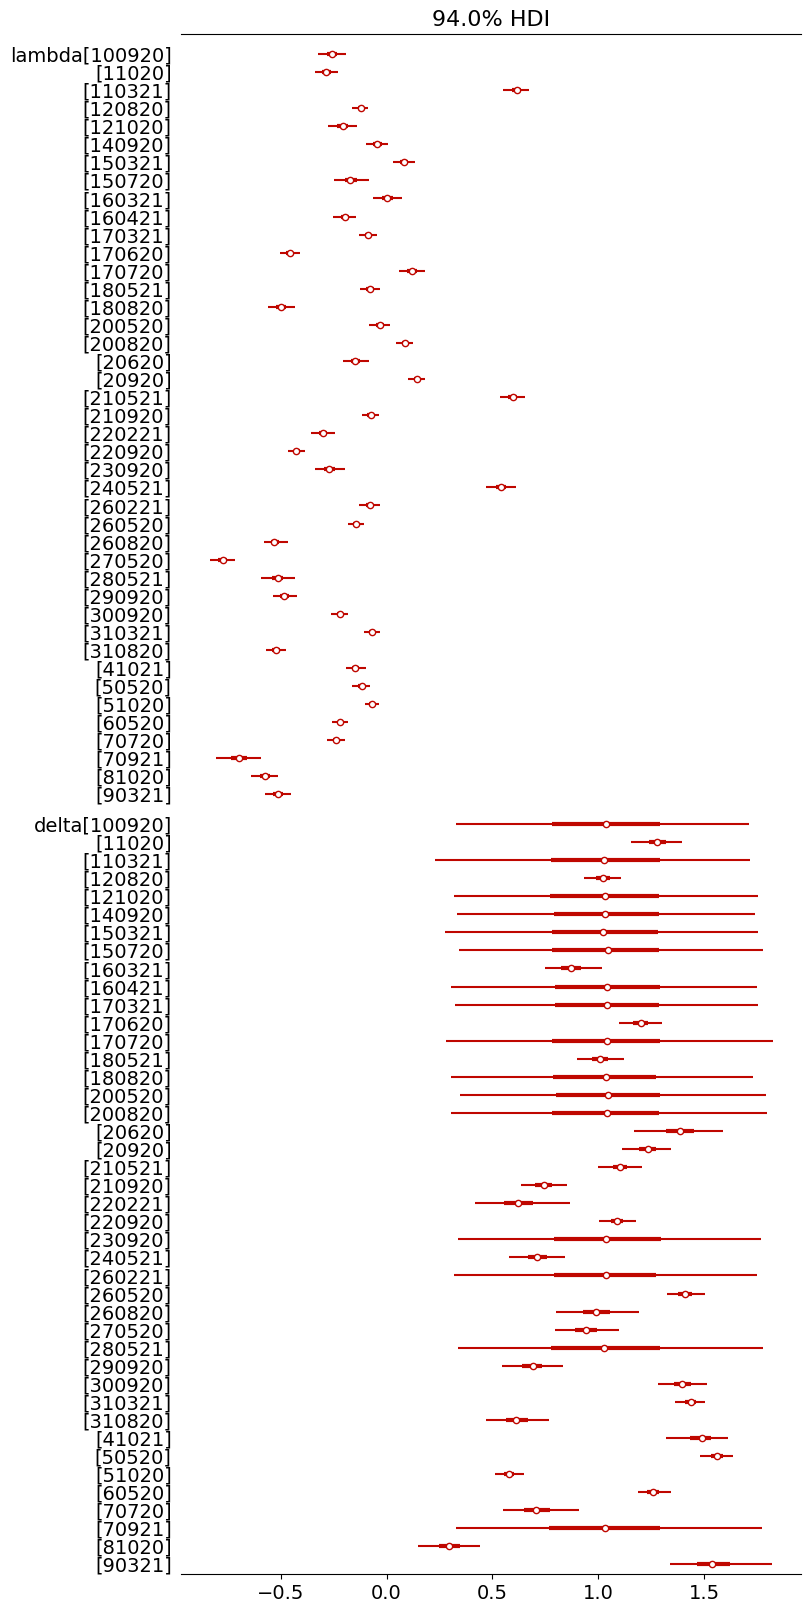

In [13]:
f, ax = plt.subplots(figsize=[8, 20])

az.plot_forest(idata, combined=True, var_names=["lambda", "delta"], ax=ax)

In [15]:
msts.loc[lambda df: df["mouse"] == 70921, ["treatment", "pressure_d"]]

,treatment,pressure_d
1484,after_ablation,41.395142
1476,after_hyper,45.621798
1464,baseline,48.764561
1472,hyper,103.460221
1492,hyper2,51.709838
1485,after_ablation,41.317516
1477,after_hyper,45.564024
1465,baseline,48.763090
1486,after_ablation,41.411967
1478,after_hyper,45.685826


In [16]:
idata.observed_data["hyper"].values

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,